In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os 
import imageio
import scipy.io as spio
import cv2
from numpy.linalg import det, inv
import matplotlib.image as mpimg
from matplotlib.widgets import PolygonSelector
from PIL import Image
import dlib

plt.style.use('default')

Task1

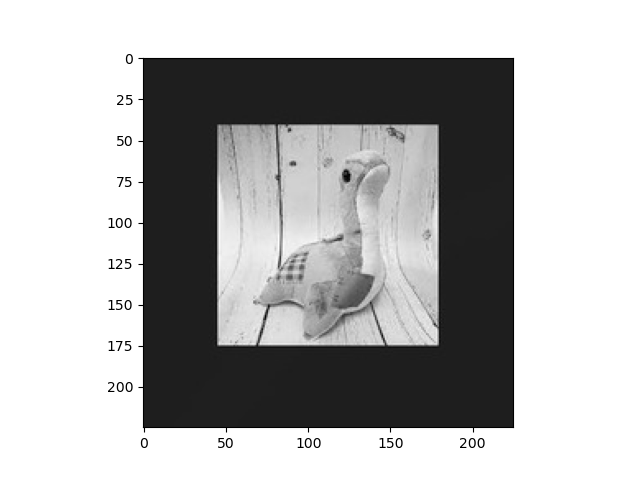

Polygon vertices:
[(46.74008139077716, 117.60064981510112), (135.01118528688107, 54.89772773717905), (171.53715931285507, 88.37987059432191), (162.40566580636158, 141.34253293198424), (104.57287359856937, 177.86850695795826), (52.827743728439486, 153.5178576073089)]


In [12]:
#img_path = "InputImgs\\1.png"
img_path = "InputImgs\\SrcImg.png"
img = Image.open(img_path).convert('L')
img_array = np.array(img, dtype=np.uint8)  # 确保数据类型为 uint8

# 回调函数，当选择完成时调用
def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)
    # 这里可以添加代码来处理多边形的顶点

# 创建图像和轴
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# 创建PolygonSelector实例
polygon_selector = PolygonSelector(ax, onselect)

# 显示图像并开始多边形选择过程
plt.show()

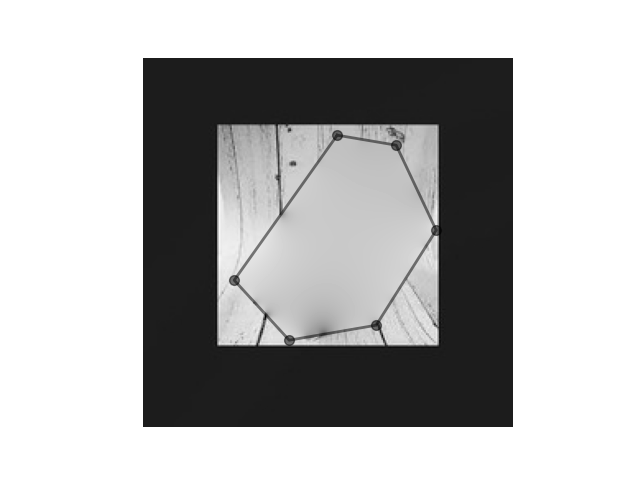

In [24]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.draw import polygon2mask
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
from skimage.color import rgb2gray

# 从上传的文件路径加载图像
image_path = "InputImgs\\SrcImg.png"
image = io.imread(image_path)
gray_image = rgb2gray(image)  # 转换为灰度图像

# 获取图像尺寸
image_height, image_width = gray_image.shape[:2]

# 创建多边形掩码
mask = polygon2mask((image_height, image_width), polygon)

# 获取多边形内部的像素索引
interior_idx = np.argwhere(mask)
#print(interior_idx)

# 初始化稀疏矩阵A和向量b
n_interior_pixels = len(interior_idx)
A = lil_matrix((n_interior_pixels, n_interior_pixels), dtype=float)
b = np.zeros(n_interior_pixels)

# 构建线性系统
for i, (row, col) in enumerate(interior_idx):
    A[i, i] = 4  # 主对角线元素
    for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 四个方向的邻居
        neighbor = (row + drow, col + dcol)
        if mask[neighbor]:  # 如果邻居在内部
            j = np.argwhere(np.all(interior_idx == neighbor, axis=1))[0, 0]
            A[i, j] = -1
        else:
            # 如果邻居在边界上或者在掩码外面，我们需要从源图像中获取对应的强度值
            b[i] += gray_image[neighbor]

# 将A矩阵转换为CSR格式
A_csr = A.tocsr()

# 求解线性系统
solution = spsolve(A_csr, b)

# 将解填充回图像的相应区域
for (solution_value, (row, col)) in zip(solution, interior_idx):
    # print(row, col)
    gray_image[row, col] = solution_value

# 显示填充后的图像
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()


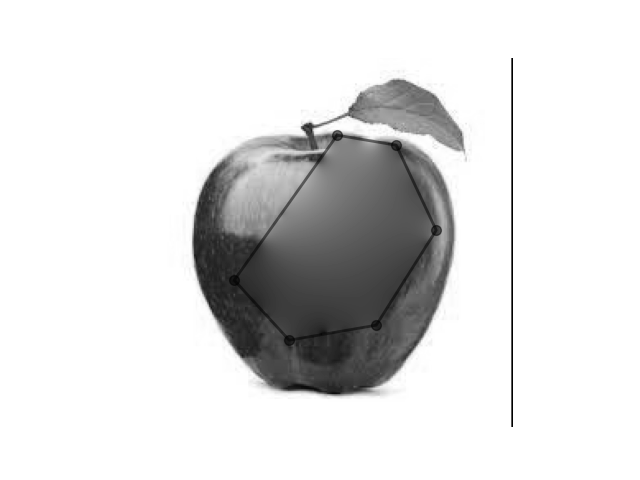

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, draw, color
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix

def compute_gradients(image):
    gx, gy = np.gradient(image)
    return gx, gy

# Load source and target images
source_image = io.imread("InputImgs\\SrcImg.png")
target_image = io.imread("InputImgs\\DstImg.png")

# Convert images to grayscale
source_gray = color.rgb2gray(source_image)
target_gray = color.rgb2gray(target_image)


# Create mask and find interior pixels
mask = draw.polygon2mask(target_image.shape[:2], polygon)
interior_idx = np.argwhere(mask)


def build_system(interior_idx, mask, target_image, source_image, method='importing'):
    n_interior_pixels = len(interior_idx)
    A = lil_matrix((n_interior_pixels, n_interior_pixels), dtype=float)
    b = np.zeros(n_interior_pixels)

    # Calculate gradients of the source and target images
    source_gx, source_gy = compute_gradients(source_image)
    target_gx, target_gy = compute_gradients(target_image)

    for i, (row, col) in enumerate(interior_idx):
        A[i, i] = 4  # Diagonal element
        for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Neighbors
            neighbor_row, neighbor_col = row + drow, col + dcol
            if mask[neighbor_row, neighbor_col]:  # If neighbor is inside the mask
                j = np.argwhere(np.all(interior_idx == [neighbor_row, neighbor_col], axis=1))[0, 0]
                A[i, j] = -1
                if method == 'mixing':
                    # Mixing gradients method
                    source_grad = (source_gx[row, col], source_gy[row, col])
                    target_grad = (target_gx[row, col], target_gy[row, col])
                    if np.linalg.norm(source_grad) > np.linalg.norm(target_grad):
                        b[i] -= source_grad[0] * drow + source_grad[1] * dcol
                    else:
                        b[i] -= target_grad[0] * drow + target_grad[1] * dcol
                elif method == 'importing':
                    # Importing gradients method
                    b[i] -= source_gx[row, col] * drow + source_gy[row, col] * dcol
            else:
                # If neighbor is outside the mask, use the target image's value
                b[i] += target_image[neighbor_row, neighbor_col]

    return A.tocsr(), b

A, b = build_system(interior_idx, mask, target_gray, source_gray, method='importing')
#A, b = build_system(interior_idx, mask, target_gray, source_gray, method='mixing')

# Solve the linear system
solution = spsolve(A, b)

# Fill the solution back into the target image
for (solution_value, (row, col)) in zip(solution, interior_idx):
    target_gray[row, col] = solution_value

# Display the result
plt.imshow(target_gray, cmap='gray')
plt.axis('off')
plt.show()

C:\Users\1\AppData\Local\Temp\ipykernel_3036\1634879330.py:40: RuntimeWarning: overflow encountered in scalar add
  b[k] = gx[y, x] + gy[y, x]
C:\Users\1\AppData\Local\Temp\ipykernel_3036\1634879330.py:38: RuntimeWarning: overflow encountered in scalar add
  b[k] = grad_x + grad_y


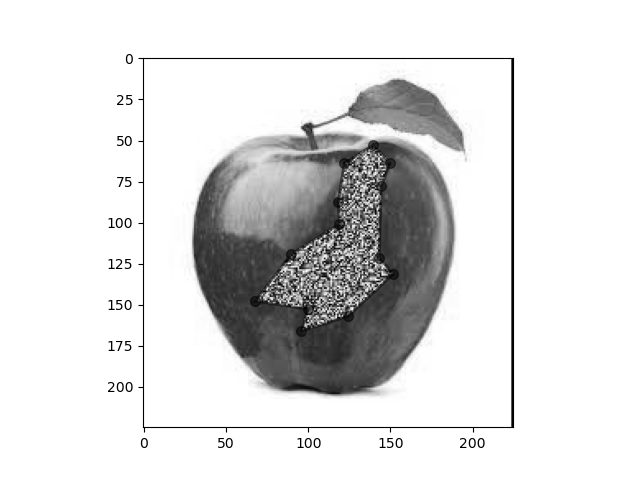

In [11]:
def compute_gradients(img):
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

# Helper function to construct the Poisson equation system
def construct_equation_system(img_shape, mask, gx, gy, mix_gradients=False, target_gx=None, target_gy=None):
    A = lil_matrix((mask.sum(), mask.sum()), dtype=np.float64)
    b = np.zeros(mask.sum(), dtype=np.float64)

    # Mapping from image coordinates to matrix indices
    indices = np.arange(img_shape[0] * img_shape[1]).reshape(img_shape)[mask]
    ind_dict = {ind: k for k, ind in enumerate(indices)}

    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    # Iterate over the mask indices and populate the matrix A and vector b
    for y in range(img_shape[0]):
        for x in range(img_shape[1]):
            if mask[y, x]:
                k = ind_dict[y * img_shape[1] + x]
                A[k, k] = 4
                if y > 0 and mask[y - 1, x]:
                    A[k, ind_dict[(y - 1) * img_shape[1] + x]] = -1
                if y < img_shape[0] - 1 and mask[y + 1, x]:
                    A[k, ind_dict[(y + 1) * img_shape[1] + x]] = -1
                if x > 0 and mask[y, x - 1]:
                    A[k, ind_dict[y * img_shape[1] + x - 1]] = -1
                if x < img_shape[1] - 1 and mask[y, x + 1]:
                    A[k, ind_dict[y * img_shape[1] + x + 1]] = -1

                # For mixing gradients, select the maximum gradient at each pixel
                if mix_gradients:
                    grad_x = gx[y, x] if np.abs(gx[y, x]) > np.abs(target_gx[y, x]) else target_gx[y, x]
                    grad_y = gy[y, x] if np.abs(gy[y, x]) > np.abs(target_gy[y, x]) else target_gy[y, x]
                    b[k] = grad_x + grad_y
                else:
                    b[k] = gx[y, x] + gy[y, x]

    return A.tocsr(), b


# Compute gradients for both images
source_gx, source_gy = compute_gradients(source_img_array)
target_gx, target_gy = compute_gradients(target_img_array)

# Construct the equation system for importing gradients
A_import, b_import = construct_equation_system(source_img_array.shape, mask, source_gx, source_gy)

# Solve the linear system for importing gradients
solution_import = spsolve(A_import, b_import)

# Construct the equation system for mixing gradients
A_mix, b_mix = construct_equation_system(source_img_array.shape, mask, source_gx, source_gy, mix_gradients=True, target_gx=target_gx, target_gy=target_gy)

# Solve the linear system for mixing gradients
solution_mix = spsolve(A_mix, b_mix)

# Fill in the cloned region with the solution for importing gradients
cloned_image_import = target_img_array.copy()
cloned_image_import[mask] = solution_import

# Fill in the cloned region with the solution for mixing gradients
cloned_image_mix = target_img_array.copy()
cloned_image_mix[mask] = solution_mix

# Convert the cloned arrays to images
cloned_img_import = Image.fromarray(cloned_image_import.astype(np.uint8))
cloned_img_mix = Image.fromarray(cloned_image_mix.astype(np.uint8))

plt.imshow(cloned_img_import, cmap='gray')
plt.show()

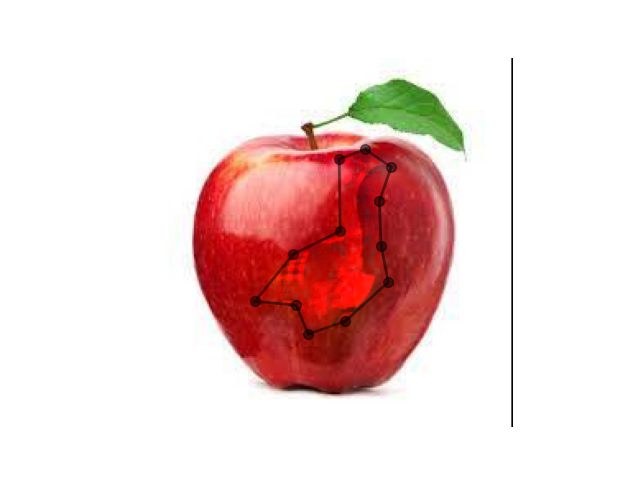

In [174]:
def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask,  mode='importing'):
    # 对于每个颜色通道
    for channel in range(3):
        # 创建拉普拉斯算子
        laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        # 计算源图像的拉普拉斯算子
        grad_source = signal.convolve2d(source_img[:, :, channel], laplacian, mode='same', boundary='fill', fillvalue=0)
        # 获取掩码内的索引
        idx = np.argwhere(mask)
        
        # 创建系数矩阵A和向量b
        n_pixels = len(idx)
        A = lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)
        
        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                    if mask[neighbor]:
                        j = np.argwhere((idx == neighbor).all(axis=1))
                        if j.size > 0:
                            A[i, j[0][0]] = -1
                    else:
                        b[i] += target_img[neighbor][channel]
        
        if mode == 'importing':
            # 使用源图像的拉普拉斯算子
            for i, (row, col) in enumerate(idx):
                b[i] += grad_source[row, col]
        elif mode == 'mixing':
            # 使用源图像和目标图像的最大梯度
            grad_target = signal.convolve2d(target_img[:, :, channel], laplacian, mode='same', boundary='fill', fillvalue=0)
            for i, (row, col) in enumerate(idx):
                if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                    b[i] += grad_source[row, col]
                else:
                    b[i] += grad_target[row, col]
        
        # 解线性方程组
        solution = spsolve(A.tocsr(), b)
         # 创建一个新的目标图像以填充结果
        cloned_img = target_img.copy()
        # 填充解决方案到结果图像
        for (row, col), value in zip(idx, solution):
            cloned_img[row, col, channel] = np.clip(value, 0, 255)
            
    return cloned_img


source_img_path = "InputImgs\\SrcImg.png"
target_img_path = "InputImgs\\DstImg.png"
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)


# 使用导入梯度
result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='mixing')

# 展示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
